Import libraries


In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader, Subset
import matplotlib.pyplot as plt
from torchvision import transforms
import torchvision
from torchvision.utils import save_image
import pandas as pd
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import fbeta_score
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import NearestNeighbors
from collections import Counter
import torch.nn as nn
import torch.optim as optim
import numpy as np
from imblearn.over_sampling import SMOTE
from collections import Counter

In [2]:
all_models = torchvision.models.list_models()
classification_models = torchvision.models.list_models(module=torchvision.models)
# print(f"all models: \n {all_models}")
print(f"classif models: \n {classification_models}")

classif models: 
 ['alexnet', 'convnext_base', 'convnext_large', 'convnext_small', 'convnext_tiny', 'densenet121', 'densenet161', 'densenet169', 'densenet201', 'efficientnet_b0', 'efficientnet_b1', 'efficientnet_b2', 'efficientnet_b3', 'efficientnet_b4', 'efficientnet_b5', 'efficientnet_b6', 'efficientnet_b7', 'efficientnet_v2_l', 'efficientnet_v2_m', 'efficientnet_v2_s', 'googlenet', 'inception_v3', 'maxvit_t', 'mnasnet0_5', 'mnasnet0_75', 'mnasnet1_0', 'mnasnet1_3', 'mobilenet_v2', 'mobilenet_v3_large', 'mobilenet_v3_small', 'regnet_x_16gf', 'regnet_x_1_6gf', 'regnet_x_32gf', 'regnet_x_3_2gf', 'regnet_x_400mf', 'regnet_x_800mf', 'regnet_x_8gf', 'regnet_y_128gf', 'regnet_y_16gf', 'regnet_y_1_6gf', 'regnet_y_32gf', 'regnet_y_3_2gf', 'regnet_y_400mf', 'regnet_y_800mf', 'regnet_y_8gf', 'resnet101', 'resnet152', 'resnet18', 'resnet34', 'resnet50', 'resnext101_32x8d', 'resnext101_64x4d', 'resnext50_32x4d', 'shufflenet_v2_x0_5', 'shufflenet_v2_x1_0', 'shufflenet_v2_x1_5', 'shufflenet_v2_x2_

In [3]:
# ResNet & DenseNet
# transform = transforms.Compose([
#     transforms.Resize(256),
#     transforms.CenterCrop(224),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
# ])

# EfficientNet_b1
# transform = transforms.Compose([
#     transforms.Resize(256),
#     transforms.CenterCrop(240),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
# ])

# RegNet
transform = transforms.Compose([
    transforms.Resize(232),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# ConvNext
# transform = transforms.Compose([
#     transforms.Resize(236),
#     transforms.CenterCrop(224),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
# ])

In [4]:
df = pd.read_csv("data/train_classes.csv")
df

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road
...,...,...
40474,train_40474,clear primary
40475,train_40475,cloudy
40476,train_40476,agriculture clear primary
40477,train_40477,agriculture clear primary road


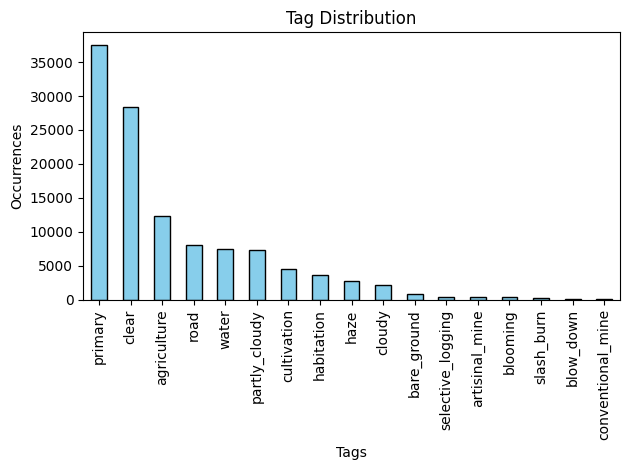

In [5]:
all_labels = df['tags'].str.split(expand=True).stack()

# Count occurrences of each label
label_counts = all_labels.value_counts()

# Plot the distribution
label_counts.plot(kind='bar', color='skyblue', edgecolor='black')

# Customize the plot
plt.title('Tag Distribution')
plt.xlabel('Tags')
plt.ylabel('Occurrences')
plt.xticks(rotation=90)
plt.tight_layout()

# Show the plot
plt.show()

In [6]:
all_tags = set()
for tags in df['tags'].str.split():
    all_tags.update(tags)

In [7]:
tag_to_idx = {tag: idx for idx, tag in enumerate(sorted(all_tags))}
idx_to_tag = {idx: tag for tag, idx in tag_to_idx.items()}
print(tag_to_idx)
print(len(tag_to_idx))

{'agriculture': 0, 'artisinal_mine': 1, 'bare_ground': 2, 'blooming': 3, 'blow_down': 4, 'clear': 5, 'cloudy': 6, 'conventional_mine': 7, 'cultivation': 8, 'habitation': 9, 'haze': 10, 'partly_cloudy': 11, 'primary': 12, 'road': 13, 'selective_logging': 14, 'slash_burn': 15, 'water': 16}
17


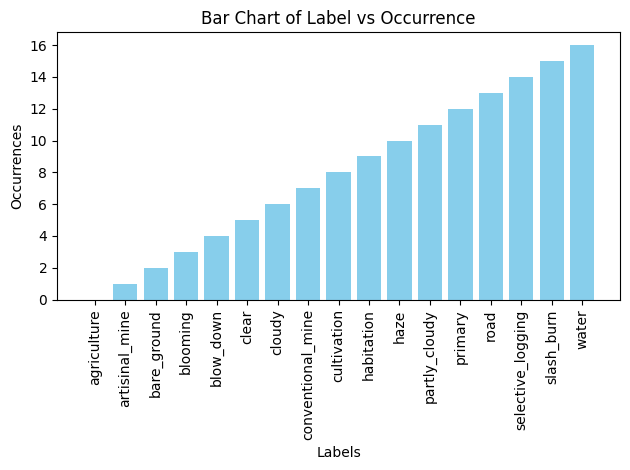

In [8]:
# Extract labels and values
labels = list(tag_to_idx.keys())
values = list(tag_to_idx.values())

# Plotting the bar chart
plt.bar(labels, values, color='skyblue')  # You can customize the color
plt.xlabel('Labels')
plt.ylabel('Occurrences')
plt.title('Bar Chart of Label vs Occurrence')
plt.xticks(rotation=90)  # Rotate labels if they are long
plt.tight_layout()  # Adjust layout to avoid overlap

# Show the plot
plt.show()

In [14]:
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import MultiLabelBinarizer
from collections import Counter

# Perform SMOTE

Preprocess DATA

In [ ]:

def load_dataset(file_path):
    df = pd.read_csv(file_path)
    
    # Binarize 'tags' column
    df_process = df.copy()
    df_process['tags_list'] = df['tags'].apply(lambda x: x.split())  # Split the 'tags' column into lists
    mlb = MultiLabelBinarizer() 
    tags_encoded = pd.DataFrame(mlb.fit_transform(df_process['tags_list']), columns=mlb.classes_, index=df_process.index)

    
    # Extract features and labels
    features = features = pd.DataFrame(df.index)  
    labels = tags_encoded
    
    # Integrate the binarized tags into the features dataframe
    # features = pd.concat([features, tags_encoded], axis=1)  # Add the binarized tags to features
    
    print(features)
    print(labels)
    return features, labels

# 2. Calculate Imbalance Measures
def calculate_imbalance_measures(labels):
    label_counts = labels.sum(axis=0)
    total_instances = len(labels)

    # IRLbl(l) = argmax_{l'∈L} (Σ_{i=1}^{|D|} h(l',Yi) / Σ_{i=1}^{|D|} h(l,Yi)) 
    IRLbl = label_counts.max() / label_counts
    MeanIR = np.mean(IRLbl)
    return IRLbl, MeanIR

# 3. Minority Instance Selection
def identify_minority_labels(IRLbl, MeanIR):
    minority_labels = [i for i, ir in enumerate(IRLbl) if ir > MeanIR]
    return minority_labels

# 4. Nearest Neighbor Search
def find_nearest_neighbors(features, k):
    nn = NearestNeighbors(n_neighbors=k)
    nn.fit(features)
    distances, indices = nn.kneighbors(features)
    return distances, indices

# 5. Feature Generation
def generate_synthetic_features(features, neighbors_indices, minority_indices, nominal_indices=None):
    """ Note: this step may be replaced with the GAN implementation"""
    synthetic_features = []
    for idx in minority_indices:
        neighbor_ids = neighbors_indices[idx]
        selected_neighbors = features.iloc[neighbor_ids]
        new_instance = {}
        
        # For numerical features
        for col in features.columns:
            if nominal_indices and col in nominal_indices:
                # Nominal: Select the most frequent value
                new_instance[col] = Counter(selected_neighbors[col]).most_common(1)[0][0]
            else:
                # Numerical: Interpolate between the instance and its neighbors
                new_instance[col] = selected_neighbors[col].mean()
        
        synthetic_features.append(new_instance)
    
    return pd.DataFrame(synthetic_features)

# 6. Labelset Generation
def generate_synthetic_labelset(labels, minority_indices, neighbors_indices):
    synthetic_labels = []
    for idx in minority_indices:
        neighbor_ids = neighbors_indices[idx]
        selected_neighbors = labels.iloc[neighbor_ids]
        # Ranking-based label generation (example: majority voting)
        new_label = selected_neighbors.mean(axis=0).round().astype(int)
        synthetic_labels.append(new_label)
    return pd.DataFrame(synthetic_labels)

# 7. Dataset Integration
def integrate_synthetic_instances(features, labels, synthetic_features, synthetic_labels):
    new_features = pd.concat([features, synthetic_features], ignore_index=True)
    new_labels = pd.concat([labels, synthetic_labels], ignore_index=True)
    return new_features, new_labels



Perform GAN

In [10]:
# Define Generator
class Generator(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, output_dim)
        )

    def forward(self, x):
        return self.model(x)

# Define Discriminator
class Discriminator(nn.Module):
    def __init__(self, input_dim):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

# Train GAN
def train_gan(minority_features, epochs=5000, batch_size=64, noise_dim=10):
    input_dim = minority_features.shape[1]  # Get the number of columns (features)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Normalize features
    scaler = MinMaxScaler()
    minority_features = scaler.fit_transform(minority_features)

    real_data = torch.tensor(minority_features, dtype=torch.float32).to(device)

    # Initialize Generator and Discriminator
    generator = Generator(noise_dim, input_dim).to(device)  # Output matches input_dim
    discriminator = Discriminator(input_dim).to(device)

    optimizer_G = optim.Adam(generator.parameters(), lr=0.001)
    optimizer_D = optim.Adam(discriminator.parameters(), lr=0.001)
    criterion = nn.BCELoss()

    for epoch in range(epochs):
        # Train Discriminator
        optimizer_D.zero_grad()
        real_labels = torch.ones((batch_size, 1)).to(device)
        fake_labels = torch.zeros((batch_size, 1)).to(device)

        real_batch = real_data[torch.randint(0, len(real_data), (batch_size,))]
        real_pred = discriminator(real_batch)
        real_loss = criterion(real_pred, real_labels)

        noise = torch.randn(batch_size, noise_dim).to(device)
        fake_data = generator(noise)
        fake_pred = discriminator(fake_data.detach())
        fake_loss = criterion(fake_pred, fake_labels)

        d_loss = real_loss + fake_loss
        d_loss.backward()
        optimizer_D.step()

        # Train Generator
        optimizer_G.zero_grad()
        fake_pred = discriminator(fake_data)
        g_loss = criterion(fake_pred, real_labels)
        g_loss.backward()
        optimizer_G.step()

        if (epoch + 1) % 1000 == 0:
            print(f"Epoch [{epoch+1}/{epochs}] D Loss: {d_loss.item():.4f} G Loss: {g_loss.item():.4f}")

    # After training, generate synthetic data
    noise = torch.randn(len(real_data), noise_dim).to(device)
    synthetic_data = generator(noise).detach().cpu().numpy()

    # Inverse transform synthetic data to match original scale
    synthetic_data = scaler.inverse_transform(synthetic_data)

    # Ensure that synthetic data has the same num
    return pd.DataFrame(synthetic_data, columns=minority_features[0])


def augment_with_gan(features, labels, minority_labels, k=5):
    # Ensure 'features' is a DataFrame, if it's a NumPy array
    if isinstance(features, np.ndarray):
        features = pd.DataFrame(features)

    # Ensure 'labels' is a DataFrame, if it's a NumPy array
    if isinstance(labels, np.ndarray):
        labels = pd.DataFrame(labels)

    # Map minority labels to column names if necessary
    minority_label_names = [labels.columns[i] for i in minority_labels]

    # Select minority class features
    minority_features = features[labels[minority_label_names].any(axis=1)]

    # Train GAN and generate synthetic features
    synthetic_features = train_gan(minority_features)

    # Ensure that synthetic features match the columns of the original 'features'
    if synthetic_features.shape[1] != features.shape[1]:
        raise ValueError("Number of columns in synthetic features does not match original features.")

    # Create synthetic labels (this assumes minority_labels corresponds to binary labels)
    synthetic_labels = pd.DataFrame(
        [minority_labels] * len(synthetic_features), 
        columns=labels.columns
    ).fillna(0).astype(int)  # Fill missing values with 0 for other labels

    # Ensure that synthetic labels match the original shape
    if synthetic_labels.shape[1] != labels.shape[1]:
        raise ValueError("Number of columns in synthetic labels does not match original labels.")

    # Integrate synthetic data
    augmented_features = pd.concat([features, synthetic_features], ignore_index=True)
    augmented_labels = pd.concat([labels, synthetic_labels], ignore_index=True)

    return augmented_features, augmented_labels





In [11]:
# Load dataset
file_path = 'data/train_classes.csv'
features, labels = load_dataset(file_path)

# Calculate imbalance measures
IRLbl, MeanIR = calculate_imbalance_measures(labels)
print("IRLbl:", IRLbl)
print("MeanIR:", MeanIR)

# Identify minority labels
minority_labels = identify_minority_labels(IRLbl, MeanIR)
print("Minority Labels:", minority_labels)

# Augment dataset using GAN
augmented_features, augmented_labels = augment_with_gan(features, labels, minority_labels)
print("Augmented Dataset Created Successfully!")

           0
0          0
1          1
2          2
3          3
4          4
...      ...
40474  40474
40475  40475
40476  40476
40477  40477
40478  40478

[40479 rows x 1 columns]
       agriculture  artisinal_mine  bare_ground  blooming  blow_down  clear  \
0                0               0            0         0          0      0   
1                1               0            0         0          0      1   
2                0               0            0         0          0      1   
3                0               0            0         0          0      1   
4                1               0            0         0          0      1   
...            ...             ...          ...       ...        ...    ...   
40474            0               0            0         0          0      1   
40475            0               0            0         0          0      0   
40476            1               0            0         0          0      1   
40477            1          

ValueError: 17 columns passed, passed data had 6 columns

In [ ]:
# Load  dataset
features, labels = load_dataset('data/train_classes.csv')

# Calculate imbalance measures
IRLbl, MeanIR = calculate_imbalance_measures(labels)
print(IRLbl)
print(MeanIR)

# Identify minority labels
minority_labels = identify_minority_labels(IRLbl, MeanIR)
print(minority_labels)


# Find k-nearest neighbors
k = 5  # Choose an appropriate value
_, neighbor_indices = find_nearest_neighbors(features, k)

# Generate synthetic features
nominal_columns = []  # Specify nominal columns if any
minority_indices = features.index  # Adjust based on label logic
synthetic_features = generate_synthetic_features(features, neighbor_indices, minority_indices, nominal_columns)

# Generate synthetic labels
synthetic_labels = generate_synthetic_labelset(labels, minority_indices, neighbor_indices)

# Integrate synthetic instances
augmented_features, augmented_labels = integrate_synthetic_instances(features, labels, synthetic_features, synthetic_labels)

print("Augmented Dataset Created Successfully!")

           0
0          0
1          1
2          2
3          3
4          4
...      ...
40474  40474
40475  40475
40476  40476
40477  40477
40478  40478

[40479 rows x 1 columns]
       agriculture  artisinal_mine  bare_ground  blooming  blow_down  clear  \
0                0               0            0         0          0      0   
1                1               0            0         0          0      1   
2                0               0            0         0          0      1   
3                0               0            0         0          0      1   
4                1               0            0         0          0      1   
...            ...             ...          ...       ...        ...    ...   
40474            0               0            0         0          0      1   
40475            0               0            0         0          0      0   
40476            1               0            0         0          0      1   
40477            1          

Combine the numerical features and labels

In [21]:
class MultiLabelImageDataset(Dataset):
    def __init__(self, csv_file, img_dir, transform=None):
        self.df = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_name = self.df.iloc[idx, 0]
        img_path = os.path.join(self.img_dir, f"{img_name}.jpg")
        image = Image.open(img_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
        
        tags = self.df.iloc[idx, 1].split()
        labels = torch.zeros(len(tag_to_idx))
        for tag in tags:
            labels[tag_to_idx[tag]] = 1
        
        return image, labels

In [22]:
def visualize_sample(dataset, idx):
    image, labels = dataset[idx]
    
    # convert the image tensor to a PIL Image for display
    if isinstance(image, torch.Tensor):
        image = transforms.ToPILImage()(image)
    
    # plot the image
    plt.figure(figsize=(10, 6))
    plt.imshow(image)
    plt.axis('off')
    
    # get the labels
    present_labels = [idx_to_tag[i] for i, label in enumerate(labels) if label == 1]
    
    # set the title with the labels
    plt.title(f"Labels: {', '.join(present_labels)}")
    plt.show()
    
    print(f"Image labels: {', '.join(present_labels)}")

In [ ]:
dataset = MultiLabelImageDataset(csv_file="data/train_classes.csv", img_dir="data/train-jpg", transform=transform)

<class '__main__.MultiLabelImageDataset'>


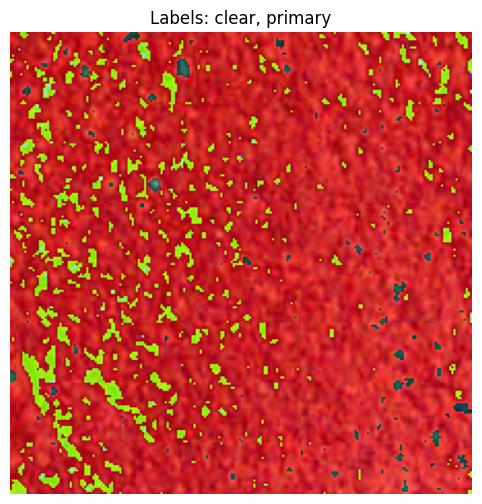

Image labels: clear, primary


In [ ]:
visualize_sample(dataset, 3)


In [12]:
train_idx, test_idx = train_test_split(list(range(len(dataset))), test_size=0.1, random_state=42)

train_dataset = Subset(dataset, train_idx)
test_dataset = Subset(dataset, test_idx)

In [13]:
batch_size = 64
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Select the device to use dynamically

In [14]:
import torch
print(torch.__version__)
print(torch.version.cuda)
torch.cuda.is_available()

2.4.1+cu118
11.8


True

In [15]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [16]:
import torchvision.models as models
from torch import nn

num_classes = 17

def ResNetClassifier(num_classes):
    # load a pre-trained model
    model_ft = models.resnet50(weights='DEFAULT')
    num_ftrs = model_ft.fc.in_features
    
    # freeze all the parameters in the network except the final layer
    # for param in model_ft.parameters():
    #     param.requires_grad = False
    
    # replace the last fully connected layer
    model_ft.fc = nn.Linear(num_ftrs, num_classes)
    return model_ft

def DenseNetClassifier(num_classes):
    # load a pre-trained model
    model_ft = models.densenet121(weights='DEFAULT')
    num_ftrs = model_ft.classifier.in_features
    
    # freeze all the parameters in the network except the final layer
    # for param in model_ft.parameters():
    #     param.requires_grad = False
    
    # replace the last fully connected layer
    model_ft.classifier = nn.Linear(num_ftrs, num_classes)
    return model_ft

def EfficientNetClassifier(num_classes):
    # load a pre-trained model
    model_ft = models.efficientnet_b1(weights='DEFAULT')
    # num_ftrs = model_ft.classifier.in_features
    
    # freeze all the parameters in the network except the final layer
    # for param in model_ft.parameters():
    #     param.requires_grad = False
    
    # replace the last fully connected layer
    model_ft.classifier = nn.Linear(1280, num_classes)
    return model_ft

def RegNetClassifier(num_classes):
    # load a pre-trained model
    model_ft = models.regnet_y_8gf(weights='DEFAULT')
    print(model_ft)
    num_ftrs = model_ft.fc.in_features
    
    # freeze all the parameters in the network except the final layer
    # for param in model_ft.parameters():
    #     param.requires_grad = False
    
    # replace the last fully connected layer
    model_ft.fc = nn.Linear(num_ftrs, num_classes)
    return model_ft

def ConvNextClassifier(num_classes):
    # load a pre-trained model
    model_ft = models.convnext_tiny(weights='DEFAULT')
    num_ftrs = model_ft.classifier[2].in_features
    
    # freeze all the parameters in the network except the final layer
    # for param in model_ft.parameters():
    #     param.requires_grad = False
    
    # replace the last fully connected layer
    model_ft.classifier = nn.Sequential(
        nn.Flatten(), 
        nn.Linear(num_ftrs, num_classes)
        )
    return model_ft

In [17]:
# model = ResNetClassifier(num_classes)
# model = DenseNetClassifier(num_classes)
# model = EfficientNetClassifier(num_classes)
model = RegNetClassifier(num_classes)
# model = ConvNextClassifier(num_classes)

model.to(device)
model

RegNet(
  (stem): SimpleStemIN(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (trunk_output): Sequential(
    (block1): AnyStage(
      (block1-0): ResBottleneckBlock(
        (proj): Conv2dNormActivation(
          (0): Conv2d(32, 224, kernel_size=(1, 1), stride=(2, 2), bias=False)
          (1): BatchNorm2d(224, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (f): BottleneckTransform(
          (a): Conv2dNormActivation(
            (0): Conv2d(32, 224, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): BatchNorm2d(224, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU(inplace=True)
          )
          (b): Conv2dNormActivation(
            (0): Conv2d(224, 224, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=4, bias=False)
      

RegNet(
  (stem): SimpleStemIN(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (trunk_output): Sequential(
    (block1): AnyStage(
      (block1-0): ResBottleneckBlock(
        (proj): Conv2dNormActivation(
          (0): Conv2d(32, 224, kernel_size=(1, 1), stride=(2, 2), bias=False)
          (1): BatchNorm2d(224, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (f): BottleneckTransform(
          (a): Conv2dNormActivation(
            (0): Conv2d(32, 224, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): BatchNorm2d(224, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU(inplace=True)
          )
          (b): Conv2dNormActivation(
            (0): Conv2d(224, 224, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=4, bias=False)
      

In [18]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        pred = model(X)
        loss = loss_fn(pred, y)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 64 == 0:
            loss, current = loss.item(), batch * batch_size + len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def test_loop(dataloader, model, loss_fn):
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, f2 = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()

            # calculate f2 score
            pred_tags = torch.sigmoid(pred).cpu().numpy() > 0.24
            true_tags = y.cpu().numpy()
            f2 += fbeta_score(true_tags, pred_tags, beta=2, average='micro')

    test_loss /= num_batches
    f2 /= num_batches
    
    print(f"Test Error: \n f2 score: {f2:.5f}, avg loss: {test_loss:>8f} \n")
    return f2, test_loss


In [19]:
print(device)

cuda


In [20]:
learning_rate = 0.001
epochs = 5

In [21]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
all_loss = []
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    f2, test_loss = test_loop(test_dataloader, model, loss_fn)
    all_loss.append(test_loss)
print("Done!")

Epoch 1
-------------------------------
loss: 0.687551  [   64/36431]
loss: 0.123218  [ 4160/36431]
loss: 0.125084  [ 8256/36431]
loss: 0.092510  [12352/36431]
loss: 0.105525  [16448/36431]
loss: 0.112593  [20544/36431]
loss: 0.106983  [24640/36431]
loss: 0.099249  [28736/36431]
loss: 0.091588  [32832/36431]
Test Error: 
 f2 score: 0.90300, avg loss: 0.092979 

Epoch 2
-------------------------------
loss: 0.099739  [   64/36431]
loss: 0.097014  [ 4160/36431]
loss: 0.104037  [ 8256/36431]
loss: 0.089022  [12352/36431]
loss: 0.092819  [16448/36431]
loss: 0.086656  [20544/36431]
loss: 0.112449  [24640/36431]
loss: 0.092476  [28736/36431]
loss: 0.131738  [32832/36431]
Test Error: 
 f2 score: 0.90693, avg loss: 0.090792 

Epoch 3
-------------------------------
loss: 0.087615  [   64/36431]
loss: 0.067714  [ 4160/36431]
loss: 0.081778  [ 8256/36431]
loss: 0.078262  [12352/36431]
loss: 0.073553  [16448/36431]
loss: 0.102717  [20544/36431]
loss: 0.101154  [24640/36431]
loss: 0.088641  [28736

[0.09297920542303473, 0.09079176787054166, 0.08766208979068324, 0.08884825283894315, 0.08952252171002328]


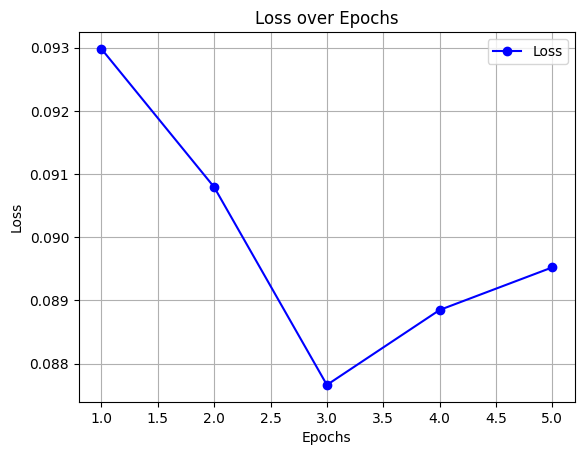

In [22]:
print(all_loss)

epochs_list = list(range(1, len(all_loss) + 1))
# print(len(all_loss))
# print(epochs)

plt.plot(epochs_list, all_loss, marker='o', color='b', label='Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()
plt.grid(True)
plt.show()

In [23]:
def predict_image(model, image_path, transform, idx_to_tag):
    model.eval()
    image = Image.open(image_path).convert('RGB')
    image = transform(image).unsqueeze(0)
    image = image.to(device)

    with torch.no_grad():
        outputs = model(image)
        probabilities = torch.sigmoid(outputs)
        predicted = probabilities > 0.24
        predicted_labels = [idx_to_tag[i] for i, pred in enumerate(predicted[0]) if pred]

    return predicted_labels, probabilities[0]

In [24]:
image_path = "data/test-jpg/test_5689.jpg"
predicted_labels, probabilities = predict_image(model, image_path, transform, idx_to_tag)

print("Predicted labels:", predicted_labels)
print("Probabilities:")
for i, prob in enumerate(probabilities):
    if prob > 0.24:
        print(f"{idx_to_tag[i]}: {prob.item():.4f}")

Predicted labels: ['clear', 'habitation', 'primary', 'road']
Probabilities:
clear: 0.9784
habitation: 1.0000
primary: 0.6124
road: 0.9999
